In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the data
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

In [3]:
# Merge Customers and Transactions data
data = transactions.merge(customers, on="CustomerID", how="left")

In [4]:
# Feature Engineering
# Calculate total spend, average transaction value, total quantity purchased, and recency
customer_features = data.groupby("CustomerID").agg({
    "TotalValue": "sum",          # Total spend
    "Quantity": "sum",            # Total quantity
    "TransactionDate": lambda x: (pd.Timestamp("2025-01-01") - pd.to_datetime(x).max()).days,  # Recency
}).rename(columns={
    "TotalValue": "TotalSpend",
    "Quantity": "TotalQuantity",
    "TransactionDate": "Recency"
}).reset_index()

In [5]:
# Add signup duration (days since signup)
customers["SignupDate"] = pd.to_datetime(customers["SignupDate"])
customers["SignupDuration"] = (pd.Timestamp("2025-01-01") - customers["SignupDate"]).dt.days

In [6]:
# Merge customer features with profile data
customer_features = customer_features.merge(customers[["CustomerID", "Region", "SignupDuration"]], on="CustomerID")

In [8]:
# One-hot encode Region
encoder = OneHotEncoder(sparse_output=False)  # Use sparse_output instead of sparse
region_encoded = encoder.fit_transform(customer_features[["Region"]])
region_df = pd.DataFrame(region_encoded, columns=encoder.get_feature_names_out(["Region"]))

In [9]:
# Combine features
features = pd.concat([customer_features.drop(columns=["CustomerID", "Region"]), region_df], axis=1)

In [10]:
# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [11]:
# Clustering
# Determine the optimal number of clusters using the Elbow method
distortions = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    distortions.append(kmeans.inertia_)

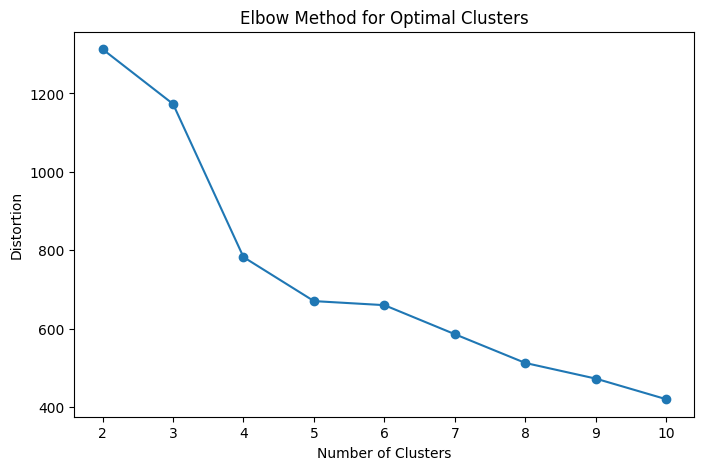

In [12]:
# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), distortions, marker="o")
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Distortion")
plt.show()

In [13]:
# Final K-Means Clustering
kmeans = KMeans(n_clusters=4, random_state=42)  # Set the desired number of clusters
clusters = kmeans.fit_predict(scaled_features)

In [14]:
# Add cluster labels to the dataset
customer_features["Cluster"] = clusters

In [15]:
# Evaluate Clustering with DB Index
db_index = davies_bouldin_score(scaled_features, clusters)
print(f"Davies-Bouldin Index: {db_index}")

Davies-Bouldin Index: 1.1259451447090436


In [16]:
# Visualize Clusters using PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

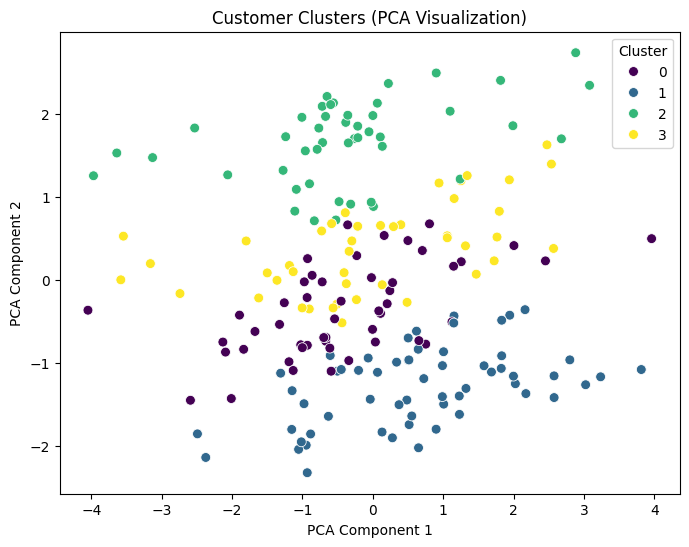

In [17]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=customer_features["Cluster"], palette="viridis", s=50)
plt.title("Customer Clusters (PCA Visualization)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()